['Malgun Gothic']
C:\Users\user\.matplotlib


C:\Users\user\AppData\Local\Temp\ipykernel_38332\2641667644.py:171: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


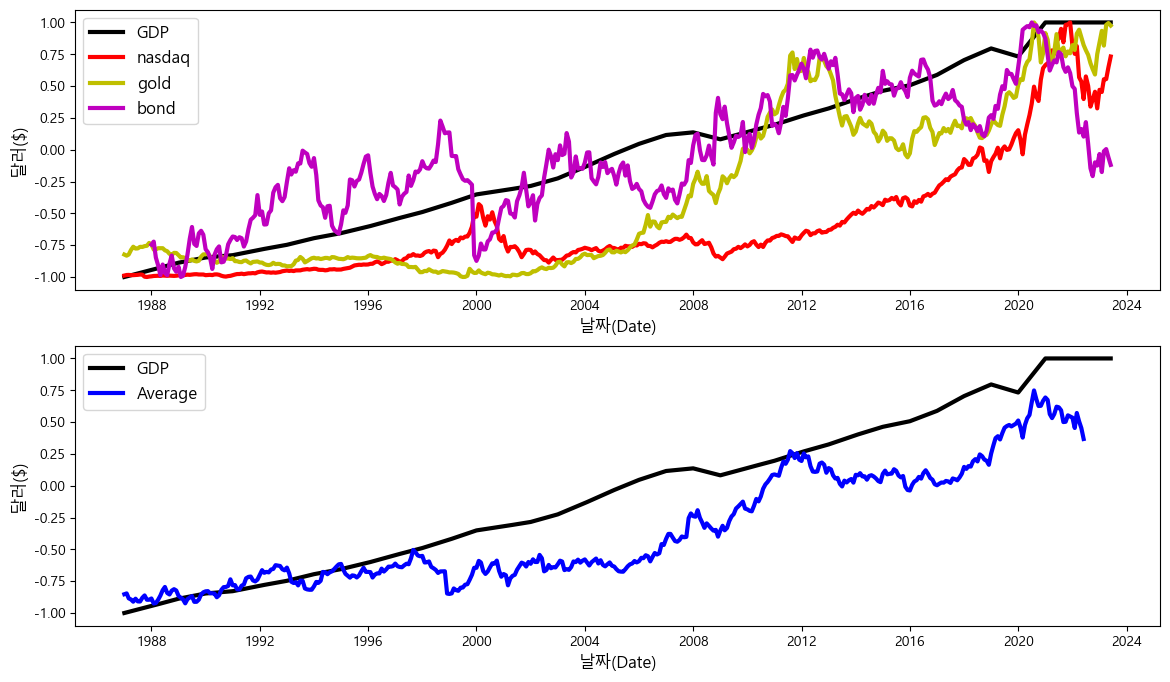

In [1]:


# 컬럼 rename 바꾸고 날짜 설정을 87년 ~ 23년도로 설정해준다. 
# 날짜 형태 전환해주고 set_index()로 index를 날짜로 변경한다.
# 데이터들은 결측치 제거를 drop()와 dropna()를 사용하고 gdp는 선형보간법 interpolate로 결측치를 채웠다.
# 중복데이터를 제거해주는 절차는 없다.
# 폰트를 설정해주고 plt.plot으로 그래프를 그려준다. 
# x축은 아까 날짜로 잡은 index를 해주고 y축은 각 데이터의 자산데이터로 해준다.
# 5가지 지표를 합쳐 상관관계를 분석한다. seaborn 라이브러리에서 set, diverging_palette, heatmap을 사용해서 plt로 보여준다.
# plot으로 그래프로 출력하였다.




import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.stats.weightstats import ztest
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from operator import itemgetter
from matplotlib.patches import Rectangle

from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy.stats as stats

# CSV 파일 불러오기
stock_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/나스닥(1985~2023)_yfinance.csv')
gold_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/금(1950~2023)_캐글.csv')
interest_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/미국금리(1954.7~2023.5)_구글서치.csv')
house_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/케이스-쉴러_미국주택가격지수(1987.1~2023.4).csv')
bond_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/10년만기 미국채 선물 과거 데이터.csv')
gdp_df = pd.read_csv('C:/Users/user/Desktop/Securities_Data_Analysis(Junsu)/dataset/original_data/1인당GDP.csv')

# 데이터프레임 컬럼 이름 바꾸기
gold_df = gold_df.rename(columns={'Price USD per Oz':'Gold_Price'})
interest_df = interest_df.rename(columns={'FEDFUNDS':'Funds_Rate', "DATE":"Date"})
house_df = house_df.rename(columns={'SPCS10RSA':'House_Price', "DATE":"Date"})
bond_df = bond_df.rename(columns={'날짜':'Date', '종가':'Bond_Close'})

# 불러올 날짜 구간 설정(공통 1987-01-01 ~ 2023-07-01)
start = "1987-01-01" # 최소 1950-01-01
end = "2023-06-01" # 최대 2023-07-01
stock_df = stock_df[stock_df['Date'].between(start, end)]
gold_df = gold_df[gold_df['Date'].between(start, end)]
interest_df = interest_df[interest_df['Date'].between(start, end)]
house_df = house_df[house_df['Date'].between(start, end)]
bond_df = bond_df[bond_df['Date'].between(start, end)]
gdp_df = gdp_df[gdp_df['Date'].between(start, end)]

# 금리를 가격화하기  +  # reset_index - 날짜 때문에 잘린 index를 0 부터 오름차순 재설정
interest_df = interest_df.reset_index(drop=True) # 날짜 자르면서 index도 같이 잘림 -> index를 0으로 초기화 시키기

interest_df['Funds_Rate'] = interest_df['Funds_Rate'] / 100 + 1 # 금리를 가격화 하기 위해 공식을 적용하여 값 변환 => 현재금리 = {(현재금리 / 100) + 1}

for i in range(len(interest_df)-1): # result = 현재 값 * 다음 값 => 복리 계산 / 기준값 = 1달러 가정
    interest_df.loc[i+1,'Funds_Rate'] = interest_df.loc[i,'Funds_Rate'] * interest_df.loc[i+1, 'Funds_Rate']

# 날짜 datatime 형식으로 전환하기
stock_df.loc[:,'Date'] = pd.to_datetime(stock_df.Date)
gold_df.loc[:,'Date'] = pd.to_datetime(gold_df.Date)
interest_df.loc[:,'Date'] = pd.to_datetime(interest_df.Date)
house_df.loc[:,'Date'] = pd.to_datetime(house_df.Date)
bond_df.loc[:,'Date'] = pd.to_datetime(bond_df.Date)
gdp_df.loc[:,'Date'] = pd.to_datetime(gdp_df.Date)

# index를 날짜로 변경하기
stock_df = stock_df.set_index('Date')
gold_df = gold_df.set_index('Date')
interest_df = interest_df.set_index('Date')
house_df = house_df.set_index('Date')
bond_df = bond_df.set_index('Date')
gdp_df = gdp_df.set_index('Date')

# 특정 칼럼(열) 삭제
stock_df = stock_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
bond_df = bond_df.drop(['시가', '고가', '저가', '변동 %'], axis = 1)

# 지수 값을 실제 가격(달러)으로 전환하기
house_df['House_Price'] = 1300 * (house_df['House_Price'])


######------------------------------------------------------- 데이터 전처리 -----------------------------------------------------------unt)

# --------------- 결측치 ---------------- #

# 선형보간법으로 빈 행 채우기(method = value : 선형 / method = time : 시간)
gdp_df = gdp_df.interpolate(method = "time")

# 결측치가 있는 행 or 열 제거하는 함수 (axis = 0 : 행 / axis = 1 : 열 / 생략 시 0 디폴트)
stock_df = stock_df.dropna(axis=0)
interest_df = interest_df.dropna(axis=0)
house_df = house_df.dropna(axis=0)
bond_df = bond_df.dropna(axis=0)
gdp_df = gdp_df.dropna(axis=1)
##ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ데이터 확인하기ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ##
# print(stock_df.head) # 총 행렬 가져오기
# print(gold_df.head)
# print(interest_df)
# print(house_df.head)
# print(bond_df.head)
# print(gdp_df.head)


# --------------- 중복치 ---------------- #
#--practice.py 참고--#
# --------------- 이상치 ---------------- #
#--practice.py 참고--#

#######---------------------------------------- 그래프그리기 ----------------------------------------------------######
### 정규화(-1 ~ 1)
scaler = MinMaxScaler(feature_range=(-1,1))

gdp_close_df = pd.DataFrame(data=gdp_df.GDP)
scaler.fit(gdp_close_df)
gdp_scaled = scaler.transform(gdp_close_df)
gdp_df_scaled = pd.DataFrame(data=gdp_scaled)

stock_close_df = pd.DataFrame(data=stock_df.Close)
scaler.fit(stock_close_df)
stock_scaled = scaler.transform(stock_close_df)
stock_df_scaled = pd.DataFrame(data=stock_scaled)

gold_close_df = pd.DataFrame(data=gold_df.Gold_Price)
scaler.fit(gold_close_df)
gold_scaled = scaler.transform(gold_close_df)
gold_df_scaled = pd.DataFrame(data=gold_scaled)

interest_close_df = pd.DataFrame(data=interest_df.Funds_Rate)
scaler.fit(interest_close_df)
interest_scaled = scaler.transform(interest_close_df)
interest_df_scaled = pd.DataFrame(data=interest_scaled)

house_close_df = pd.DataFrame(data=house_df.House_Price)
scaler.fit(house_close_df)
house_scaled = scaler.transform(house_close_df)
house_df_scaled = pd.DataFrame(data=house_scaled)

bond_close_df = pd.DataFrame(data=bond_df.Bond_Close)
scaler.fit(bond_close_df)
bond_scaled = scaler.transform(bond_close_df)
bond_df_scaled = pd.DataFrame(data=bond_scaled)



# 전역으로 그래프 사이즈 고정
plt.rcParams["figure.figsize"] = (14,8)

# 유니코드 깨짐현상 해결
plt.rcParams['axes.unicode_minus'] = False
 
# 나눔고딕 폰트 적용
# 폰트 한글 이슈 -  C:\ProgramData\Anaconda3\Lib\site-packages\matplotlib\mpl-data 여기서 matplotlibrc를 메모장으로 열어서 
#font.family:  sans-serif -> NanumGothic으로 변경
# plt.rcParams["font.family"] = 'NanumGothic'
# plt.rc('font', family='Malgun Gothic')
plt.rcParams["font.family"] = 'Malgun Gothic'
print(plt.rcParams['font.family'])
print(matplotlib.get_cachedir())



# # 그래프 타이틀
# plt.title('GDP & 4-asset (' + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", fontsize=20) 
plt.title('(' + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", fontsize=20) 


plt.subplot(211)
# 데이터 주입 표준화(X)
# # plt.plot(gdp_df.index, gdp_df.GDP, color='black', linewidth = 3)
# plt.plot(stock_df.index, stock_df.Close, color='r', linewidth = 3)
# plt.plot(gold_df.index, gold_df.Gold_Price, color='y', linewidth = 3)
# # plt.plot(house_df.index, house_df.House_Price, color='b', linewidth = 3)
# # plt.plot(interest_df.index, interest_df.Funds_Rate, color='g', linewidth = 3)
# plt.plot(bond_df.index, bond_df.Bond_Close, color='m', linewidth = 3)

# 데이터 주입 표준화(O)
plt.plot(gdp_df.index, gdp_df_scaled, color='black', linewidth = 3)
plt.plot(stock_df.index, stock_df_scaled, color='r', linewidth = 3)
plt.plot(gold_df.index, gold_df_scaled, color='y', linewidth = 3)
plt.plot(bond_df.index, bond_df_scaled, color='m', linewidth = 3)

# x축, y축, 각 데이터의 이름 설정
plt.ylabel('달러($)', fontsize=12)
plt.xlabel('날짜(Date)', fontsize=12)
plt.legend(['GDP' ,'nasdaq', 'gold', 'bond'], fontsize=12, loc='best')





plt.subplot(212)
plt.plot(gdp_df.index, gdp_df_scaled, color='black', linewidth = 3)

# 데이터 표준화(X)
# average_line = (stock_df.Close + gold_df.Gold_Price + bond_df.Bond_Close) / 3
# 데이터 표준화(O)
average_line = (stock_df_scaled + gold_df_scaled + bond_df_scaled) / 3
average_line_date = (stock_df.Close + gold_df.Gold_Price + bond_df.Bond_Close) / 3
plt.plot(average_line_date.index, average_line, color='b', linewidth=3)

# x축, y축, 각 데이터의 이름 설정
plt.ylabel('달러($)', fontsize=12)
plt.xlabel('날짜(Date)', fontsize=12)
plt.legend(['GDP', 'Average'], fontsize=12, loc='best')



## ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ상관분석ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
# # 상관분석을 한번에 하기 위해 5가지 지표 합치기
economic_df = pd.concat([gdp_df, stock_df, gold_df, house_df, interest_df, bond_df], axis = 1)

# # 합친 데이터프레임의 열 이름 변환
economic_df.columns = ['GDP', '주가', '금', '부동산', '금리', '채권']

# # 상관관계 분석 함수 사용
economic_cor = economic_df.corr()
# print(economic_cor)

# # heatmap 설정 후 그리기
# sns.set(style="white", font="Malgun Gothic", rc={"axes.unicode_minus":False})
# f, ax = plt.subplots(figsize=(5, 5)) # 표준화 된 지표 상관분석 표
# cmap = sns.diverging_palette( 0, 10, center='light', as_cmap=True)

# sns.heatmap(economic_cor, cmap = cmap, center=0.0, square=True,
#             linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True)

# heatmap 타이틀과 x축, y축 이름 설정
# plt.title("GDP & 5-asset (" + start[2:4] + "." + start[5:7]+ "~" + end[2:4] + "." + end[5:7] + ")", size=15)
# ax.set_xticklabels(list(economic_cor.columns), size=10, rotation=90)
# ax.set_yticklabels(list(economic_cor.columns), size=10, rotation=0)

# 그래프, heatmap 동시 출력
plt.show()
